mimic simulation 7, treat features as continuous  

Simulate coordinates in the embedding space

The first two are simulated from Gaussian, the rest are simulated by random noise

Round all coordinates



In [1]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")
sys.path.append("/home/wanxinli/deep_patient/")

from common import *
from deep_patient.sda import SDA
from math import floor, exp
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import poisson, normal
from numpy.random import dirichlet
from random import randint
import theano.tensor as T
import os
import ot.plot
from sklearn import linear_model
from sklearn import svm
from sklearn import preprocessing
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA

from sim_common import *

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/synthetic")


In [3]:
def simulate_emb_label(dataset, n, num_features, mu_1, mu_2, nz=.5, theta=0, p=.5, random_state=None, **kwargs):
    """ Simulate desired embeddings and labels
 
    Parameters
    ----------
    dataset : str
        type of classification problem (see code)
    n : int
        number of training samples
    num_features: int
        number of features
    nz : float
        noise level (>0)
    p : float
        proportion of one class in the binary setting
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : ndarray, shape (n, d), the desired embedding
        `n` observation of size `d`
    y : ndarray, shape (n,), the labels
        labels of the samples.
    """
    
    generator = check_random_state(random_state)

    if dataset.lower() == '2gauss': # this pair of simulation can be transported well
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = mu_1[0]
        x[y == 1, 1] = mu_1[1]
        x[y == 2, 0] = mu_2[0]
        x[y == 2, 1] = mu_2[1]
        x[y != 2, :] += 1.5 * nz * generator.randn(sum(y != 2), 2)
        x[y == 2, :] += 2 * nz * generator.randn(sum(y == 2), 2)
    elif dataset.lower() == '2gauss2':
        y = np.floor((np.arange(n) * 1.0 / n * 2)) + 1
        x = np.zeros((n, 2))
        # class 1
        x[y == 1, 0] = mu_1[0]
        x[y == 1, 1] = mu_1[1]
        x[y == 2, 0] = mu_2[0]
        x[y == 2, 1] = mu_2[1]
        x[y != 2, :] += 1 * nz * generator.randn(sum(y != 2), 2)
        x[y == 2, :] += 2 * nz * generator.randn(sum(y == 2), 2)
    
    # pad noise to the remaining dimensions
    new_x = []
    ori_dim = x.shape[1]
    for i in range(x.shape[0]):
        cur_x = x[i].tolist()
        cur_x.extend(normal(0, 0.01, num_features-ori_dim))
        new_x.append(cur_x)
        
    return np.array(new_x), y.astype(int)

In [4]:
def sim_wrapper(num_patient = 1000):
    target_coords, target_labels = simulate_emb_label('2gauss', num_patient, 20, [-1, 1], [1, 0], nz=0.5)
    source_coords, source_labels = simulate_emb_label('2gauss2', num_patient, 20, [-2, -2], [2, 0], nz=0.5)
    target_features = coords2features(target_coords)
    source_features = coords2features(source_coords)
    return source_features, source_labels, target_features, target_labels
    

In [5]:
source_accuracies, source_precisions, source_recalls, source_f1s, \
    target_accuracies, target_precisions, target_recalls, target_f1s, \
    trans_target_accuracies, trans_target_precisions, trans_target_recalls, trans_target_f1s  = \
    run_proc_multi(sim_wrapper, features2embs, svm.SVC, max_iter=100000, n_times=100)

iteration: 0
iteration: 1
iteration: 2
iteration: 3


KeyboardInterrupt: 

In [ ]:
score_path = os.path.join(output_dir, "sim11_svm_scores.csv")
save_scores(source_accuracies, source_precisions, source_recalls, source_f1s, \
        target_accuracies, target_precisions, target_recalls, target_f1s, \
        trans_target_accuracies, trans_target_precisions, trans_target_recalls, trans_target_f1s, score_path)

average trans target to target precision is: 1.2746454225109383
median trans target to target precision is: 0.9361921289332429
average trans source to source recall is: 2.124524485576654
median trans source to source recall is: 1.3854287556415215
average trans target to target f1 is: 1.0973255724497306
median trans target to target f1 is: 1.0910214004507088


<Figure size 432x288 with 0 Axes>

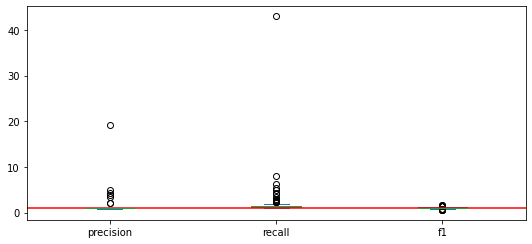

In [3]:
score_path = os.path.join(output_dir, "sim11_svm_scores.csv")
box_plot_binary_short(score_path)

In [6]:
""" 
One run of the experiment
"""
source_features, source_labels, target_features, target_labels = sim_wrapper(100)
source_embs, target_embs = features2embs(source_features, target_features)
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, log=True, max_iter=100000)
ot_sinkhorn.fit(Xs=target_embs, Xt=source_embs)
trans_target_embs = ot_sinkhorn.transform(Xs=target_embs)


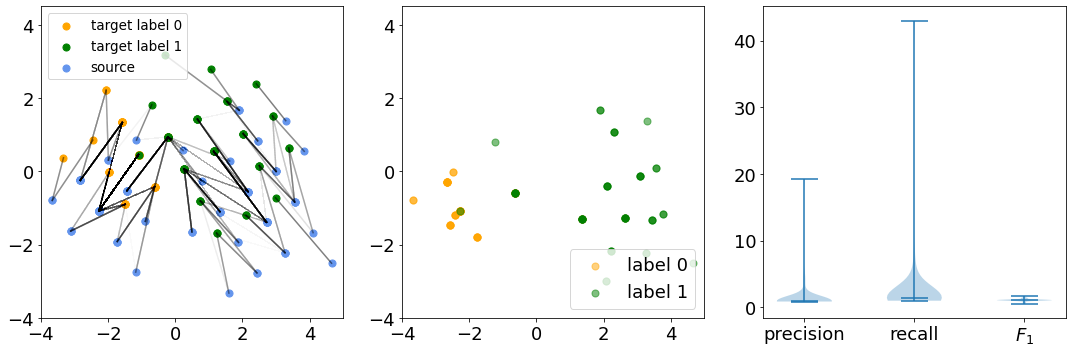

In [11]:
""" 
Generate the figure for the manuscript
"""

plt.figure(1, figsize=(15, 5))

text_size=18
title_size=22
dot_size = 50

plt.subplot(1, 3, 1)
target_label_0 = []
target_label_1 = []
for i in range(len(target_labels)):
    if target_labels[i] == 1:
        target_label_0.append(i)
    else:
        target_label_1.append(i)

plt.scatter(target_embs[target_label_0, 0], target_embs[target_label_0, 1], c = "orange", label="target label 0", s=dot_size)
plt.scatter(target_embs[target_label_1, 0], target_embs[target_label_1, 1], c = "green", label="target label 1", s=dot_size)
plt.scatter(source_embs[:, 0], source_embs[:, 1], label="source", c="cornflowerblue", s=dot_size)
plt.xlim(-4, 5)
plt.ylim(-4, 4.5)
plt.tick_params(labelsize=text_size)
ot.plot.plot2D_samples_mat(target_embs, source_embs, ot_sinkhorn.coupling_, c="black", alpha=0.5)
plt.legend(fontsize=text_size*0.75)
# plt.title(r"$\bf{(a)}$ Transport plan", x=0.28, fontsize=title_size)

plt.subplot(1, 3, 2)
plt.scatter(trans_target_embs[target_label_0, 0], trans_target_embs[target_label_0, 1],c="orange", alpha = 0.5, marker='o', label="label 0", s=dot_size)
plt.scatter(trans_target_embs[target_label_1, 0], trans_target_embs[target_label_1, 1],c="green", alpha = 0.5, marker='o', label="label 1", s=dot_size)
plt.tick_params(labelsize=text_size)
plt.legend(fontsize=text_size, loc="lower right")
plt.xlim(-4, 5)
plt.ylim(-4, 4.5)

# pl.legend(loc=0)
# plt.title(r'$\bf{(b)}$ Transported target'+'\n'+'embedding', x=0.35, fontsize=title_size)

ax3 = plt.subplot(1, 3, 3)

score_path = os.path.join(output_dir, "sim11_svm_scores.csv")

scores_df = pd.read_csv(score_path, index_col=None, header=0)

source_precision = scores_df['source_precision']
source_recall = scores_df['source_recall']
source_f1 = scores_df['source_f1']

target_precision = scores_df['target_precision']
target_recall = scores_df['target_recall']
target_f1 = scores_df['target_f1']

trans_target_precision = scores_df['trans_target_precision']
trans_target_recall = scores_df['trans_target_recall']
trans_target_f1 = scores_df['trans_target_f1']

# transported source to target recall
trans_target_target_precision = [i / j for i, j in zip(trans_target_precision, target_precision)]

# transported source to source recall
trans_target_target_recall = [i / j for i, j in zip(trans_target_recall, target_recall)]

# transported source to source f1
trans_target_target_f1 = [i / j for i, j in zip(trans_target_f1, target_f1)]

# Pandas dataframe
data = pd.DataFrame({
    'Precision': trans_target_target_precision,
    'Recall': trans_target_target_recall,
    r'$F_1$': trans_target_target_f1
})

# Plot the baseline
# ax3.axhline(y = 1, color = 'r', linestyle = '-')
# ax3.set_title(r"$\bf{(c)}$ performance ratio"+"\n"+r"$\ \ $"+"          with/without transport", x=0.28, fontsize=title_size)
ax3.violinplot(data, showmedians=True)
ax3.set_xticks([1,2,3])
ax3.set_xticklabels(['precision', 'recall', r'$F_1$'], fontsize=text_size)
ax3.yaxis.set_tick_params(labelsize=text_size)

plt.tight_layout()
save_path = os.path.join(output_dir, "sim11_res.pdf")
plt.savefig(save_path, bbox_inches = 'tight')

plt.show()